# 状態空間モデルによる欠損値補完

ローカルレベルトレンドモデルによる欠損値補完

## データ
- N : 全区間のデータ数
- M : 観測データ数
- L : 欠損データ数
- Y : 観測データ
- missing_index : 欠損データのインデックス

## パラメータ
- mu : 状態
- sigma_mu : システムモデル分散
- sigma_Y : 観測モデル分散

## モデル
- $\mu_{t} \sim Normal(\mu_{t-1},\sigma_{\mu}) $

- $Y_{t} \sim Normal(\mu_{t},\sigma_{Y}) $

In [1]:
%matplotlib inline
import pystan
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 12)

In [15]:
stan_code = """
data {
    int N;
    int L;
    vector[N] Y;
    int missing_index[L];
}

parameters {
    vector[N] mu;
    real<lower=0> s_mu;
}

model {
    int cnt;
    cnt = 1;
    
    mu[3:N] ~ normal(2*mu[2:(N-1)]-mu[1:(N-2)],s_mu);

    for(i in 1:N){
        if(missing_index[cnt] ==i){
            if(cnt < L)
                cnt = cnt + 1;
        }else{
            Y[i] ~ normal(mu[i],1);
        }
    }
}

generated quantities{
    vector[L] missing_values;
    for(i in 1:L){
        missing_values[i] = normal_rng(mu[missing_index[i]],1);
    }
}
"""

In [16]:
N=50
y=np.linspace(0,10,N) + np.random.normal(0,10,size=N)

missing_index = np.array(range(6,12))

stan_dat = {
    'N': len(y),
    'L': len(missing_index),
    'Y': y,
    'missing_index' : missing_index + 1
}
fit = pystan.stan(model_code = stan_code, data = stan_dat, iter = 2500, chains = 4)

In [17]:
fit

Inference for Stan model: anon_model_af53f410affcabb136e873dae503f019.
4 chains, each with iter=2500; warmup=1250; thin=1; 
post-warmup draws per chain=1250, total post-warmup draws=5000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]              -1.21    0.01   0.99  -3.17  -1.88   -1.2  -0.54   0.73   5000    1.0
mu[1]             -16.86    0.01   0.96 -18.75 -17.53 -16.86 -16.19 -14.98   5000    1.0
mu[2]              -0.43    0.01   0.98  -2.33  -1.11  -0.44   0.25   1.46   5000    1.0
mu[3]               6.14    0.01   0.99   4.24   5.45   6.13   6.81   8.07   5000    1.0
mu[4]              19.97    0.01    1.0  18.04  19.29  19.98  20.63  21.98   5000    1.0
mu[5]               5.62    0.01    1.0   3.66   4.93   5.63    6.3   7.57   5000    1.0
mu[6]              -3.58    0.34  19.07 -41.01 -16.15   -3.8   8.88  33.93   3108    1.0
mu[7]              -9.51    0.66   32.9 -75.11 -31.38  -9.19  11.79   55.3   2520    1.0
mu[8]     

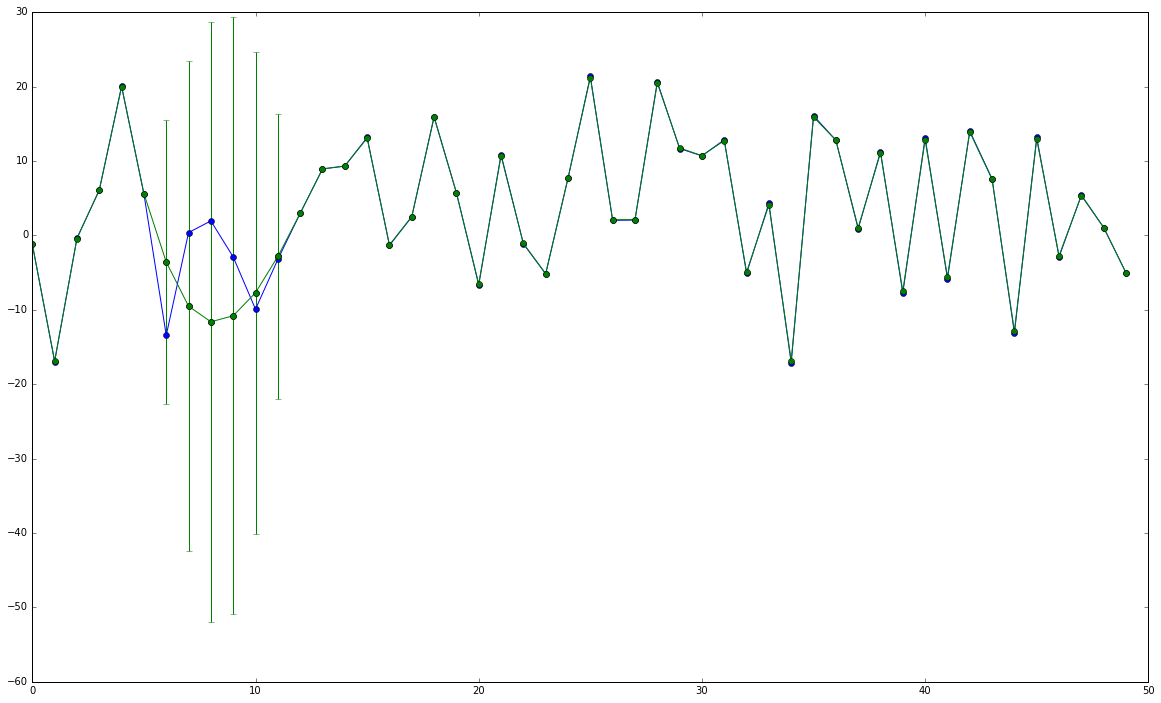

In [18]:
ms=fit.extract()

plt.plot(y,"bo-")
plt.plot(np.mean(ms["mu"],axis=0),"go-")

mv_mu=np.mean(ms["missing_values"] ,axis=0)
mv_std=np.std(ms["missing_values"] ,axis=0)

for i,ix in enumerate(missing_index):
    plt.errorbar(ix,mv_mu[i],yerr=mv_std[i],fmt='ro',ecolor='g',color="g")